In [1]:
!ls *h5

vae_mlp_mnist.h5


In [2]:
#https://github.com/keras-team/keras/tree/master/examples

In [3]:
import h5py

In [4]:
##just the raw file
model_vae=h5py.File("vae_mlp_mnist.h5", 'r')

In [5]:
list(model_vae.keys())

['decoder', 'encoder', 'encoder_input']

In [6]:
list(model_vae['decoder'].keys())

['dense_2', 'dense_3']

In [7]:
#this is the way to load keras models (not only the weights)
#from keras.models import load_model
#model = load_model('vae_mlp_mnist.h5')

#however, it did not work here because only weights were saved in the .h5 file; the actual model wasn't saved

In [8]:
#in order to load the weights, I need to create a model first
#

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [9]:
vae.load_weights("vae_mlp_mnist.h5",by_name=True)

In [10]:
vae.predict_generator

<bound method Model.predict_generator of <keras.engine.training.Model object at 0x182ed15b38>>

In [11]:
encoder.weights

[<tf.Variable 'dense_1/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'z_mean/kernel:0' shape=(512, 2) dtype=float32_ref>,
 <tf.Variable 'z_mean/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'z_log_var/kernel:0' shape=(512, 2) dtype=float32_ref>,
 <tf.Variable 'z_log_var/bias:0' shape=(2,) dtype=float32_ref>]

In [12]:
x_train.shape

(60000, 784)

In [13]:
vae.layers #Input, Encoder, Decoder?  #looks like it is the case

Use the decoder part as the generative model below:

In [14]:
z_sample=np.array([[1, 0.1]])
decoded1=vae.layers[2].predict(z_sample)
decoded1.shape

(1, 784)

In [15]:
decoded1=decoded1.reshape(28,28)
decoded1.shape

(28, 28)

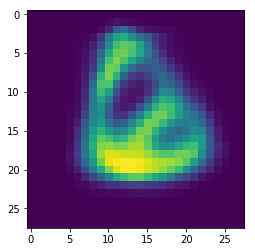

In [16]:
plt.imshow(decoded1)

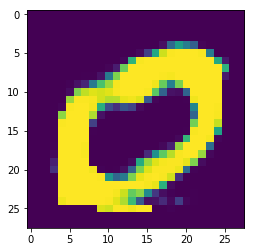

In [17]:
z_sample=np.array([[8, 2]])
decoded1=vae.layers[2].predict(z_sample)
decoded1=decoded1.reshape(28,28)
plt.imshow(decoded1)

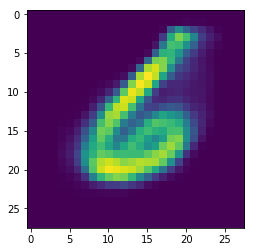

In [18]:
z_sample=np.array([[1, 2]])
decoded1=vae.layers[2].predict(z_sample)
decoded1=decoded1.reshape(28,28)
plt.imshow(decoded1)

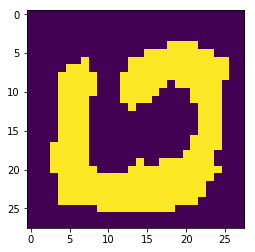

In [19]:
z_sample=np.array([[1000, 20]])
decoded1=vae.layers[2].predict(z_sample)
decoded1=decoded1.reshape(28,28)
plt.imshow(decoded1)

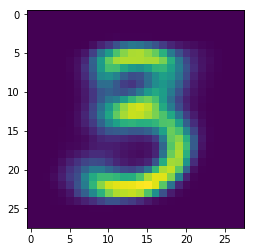

In [20]:
z_sample=np.array([[0.01, 0.2]])
decoded1=vae.layers[2].predict(z_sample)
decoded1=decoded1.reshape(28,28)
plt.imshow(decoded1)

Try to check the whole

In [21]:
number=x_train[0].reshape(784,)
number.shape

(784,)

In [22]:
x_train.shape

(60000, 784)

In [23]:
k1=vae.predict(x_train[0:3])
k1.shape

(3, 784)

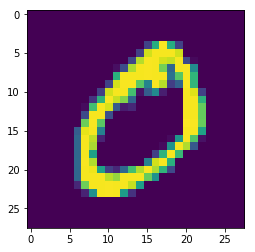

In [24]:
#2nd input for the vae model
plt.imshow(x_train[1].reshape(28,28))

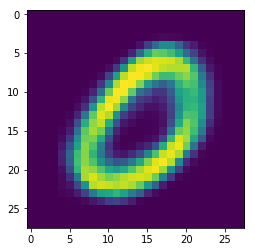

In [25]:
#vae out for the 2nd input
plt.imshow(k1[1].reshape(28,28))
#you can see from the example that the generated result is similar but not the same

In [26]:
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [27]:
vae.layers

In [28]:
vae.predict(x_train[0:1])

array([[1.63010250e-09, 5.20140264e-10, 9.89042848e-10, 1.26769828e-09,
        2.24369012e-09, 9.95213689e-10, 1.36687861e-09, 1.58576408e-09,
        2.10556195e-09, 1.89488381e-09, 1.22232569e-09, 8.16094636e-10,
        1.55441133e-12, 1.57509350e-16, 2.89801311e-16, 9.18253196e-10,
        1.57698699e-09, 1.32295053e-09, 1.27465183e-09, 1.66039649e-09,
        1.24821098e-09, 6.43878340e-10, 2.01212091e-09, 2.18939200e-09,
        1.17763099e-09, 1.58287827e-09, 1.62903635e-09, 1.12254439e-09,
        1.25770583e-09, 9.79328507e-10, 6.50543119e-10, 2.56177346e-09,
        1.86510785e-09, 6.31555829e-14, 3.34685321e-20, 1.07830757e-13,
        1.34023087e-17, 1.04890741e-14, 9.30659584e-17, 5.87151907e-18,
        8.08296162e-18, 1.47539185e-15, 2.58614554e-15, 1.69162678e-14,
        2.26553083e-13, 1.21860213e-11, 1.02558034e-12, 5.64270419e-12,
        2.08692803e-11, 3.78194004e-10, 5.21135489e-13, 1.16565641e-18,
        1.35571376e-09, 9.57874891e-10, 1.08604814e-09, 9.593558

In [29]:
output2=vae.predict(x_train[0].reshape(1,784))   #the single input just needs to get reshaped into 1 X 784 to work with the network architecture

In [30]:
#plt.imshow(output2.reshape(28,28)) #this generates the digit figure

In [31]:
x_train[0].shape

(784,)

In [32]:
x_train[0:1].shape

(1, 784)

In [33]:
data0=x_train[0:1]
data0.shape

(1, 784)

In [34]:
#use the encoder model to get the latent embedding
vae.layers[1].predict(x_train[0:1])

[array([[-0.09002593,  0.54926664]], dtype=float32),
 array([[-6.5126686, -6.269787 ]], dtype=float32),
 array([[-0.08121015,  0.55250716]], dtype=float32)]

In [35]:
vae.layers[1].predict(x_train[0].reshape(1,784))  #this also works

[array([[-0.09002593,  0.54926664]], dtype=float32),
 array([[-6.5126686, -6.269787 ]], dtype=float32),
 array([[-0.11310914,  0.5424645 ]], dtype=float32)]

The following code explores the different layers of the model;
it clearly shows how the whole works and flows

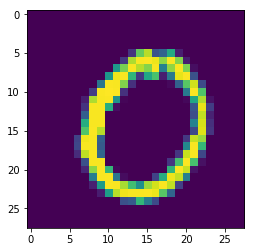

In [36]:
#check the input image
#for a random input, No.101 image in x_test
plt.imshow(x_test[101].reshape(28,28))

In [37]:
#check the latent embedding results:
vae.layers[1].predict(x_test[101].reshape(1,784))

[array([[2.1871598, 0.4526646]], dtype=float32),
 array([[-5.1347213, -5.400489 ]], dtype=float32),
 array([[2.174407  , 0.51319104]], dtype=float32)]

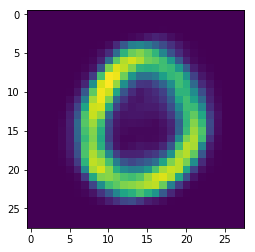

In [38]:
#check the VAE outputs:
plt.imshow(vae.layers[2].predict(np.array([[2.142959 , 0.4216305]])).reshape(28,28))

I want to check the input and output shape of the model

In [39]:
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [40]:
vae.layers[1].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [41]:
vae.layers[0].summary()

AttributeError: 'InputLayer' object has no attribute 'summary'

In [42]:
vae.layers[2].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [44]:
z_value_example=np.array([[-0.08121015,  0.55250716]])
z_value_example.shape

(1, 2)

In [49]:
#plot_model(vae) #this creates a "model.png" file; it is not going to generate a figure in the notebook
plot_model(vae,to_file="reload_saved_vae_model.png")

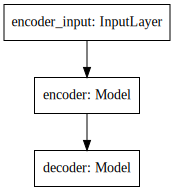

In [47]:
#in place model display
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))